In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = convolution_block(
        residual_block_pool, residual_convolution_options)
    residual_block = convolution_block(
        residual_block, residual_convolution_options)

    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_block(averaged_embedding_layer, should_pool = False)
model = residual_block(model, should_pool = True)
model = residual_block(model, should_pool = True)
model = residual_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 9:36 - loss: 0.1199 - acc: 0.9595

102112/102124 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9735

102124/102124 [==============================] - 762s 7ms/step - loss: 0.0766 - acc: 0.9735 - val_loss: 0.0522 - val_acc: 0.9813
Epoch 2/32
 10144/102124 [=>............................] - ETA: 10:35 - loss: 0.0594 - acc: 0.9785

102112/102124 [============================>.] - ETA: 0s - loss: 0.0569 - acc: 0.9792

102124/102124 [==============================] - 755s 7ms/step - loss: 0.0569 - acc: 0.9792 - val_loss: 0.0471 - val_acc: 0.9821
roc-auc: 0.9788 - roc-auc_val: 0.9762                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 10:42 - loss: 0.0500 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9804

102124/102124 [==============================] - 755s 7ms/step - loss: 0.0532 - acc: 0.9804 - val_loss: 0.0471 - val_acc: 0.9816
Epoch 4/32
 10144/102124 [=>............................] - ETA: 10:29 - loss: 0.0516 - acc: 0.9807

102112/102124 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9811

102124/102124 [==============================] - 754s 7ms/step - loss: 0.0503 - acc: 0.9811 - val_loss: 0.0492 - val_acc: 0.9809

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00036602141335606575.
roc-auc: 0.9862 - roc-auc_val: 0.9822                                                                                                    
Epoch 5/32
  5920/102124 [>.............................] - ETA: 11:01 - loss: 0.0491 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9816

102124/102124 [==============================] - 756s 7ms/step - loss: 0.0488 - acc: 0.9816 - val_loss: 0.0435 - val_acc: 0.9833
Epoch 6/32
 10144/102124 [=>............................] - ETA: 10:33 - loss: 0.0453 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9821

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0471 - acc: 0.9821 - val_loss: 0.0454 - val_acc: 0.9823
roc-auc: 0.9878 - roc-auc_val: 0.9839                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 10:43 - loss: 0.0487 - acc: 0.9810

102112/102124 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9823

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0463 - acc: 0.9823 - val_loss: 0.0450 - val_acc: 0.9824
Epoch 8/32
 10144/102124 [=>............................] - ETA: 10:33 - loss: 0.0457 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9826

102124/102124 [==============================] - 756s 7ms/step - loss: 0.0454 - acc: 0.9826 - val_loss: 0.0429 - val_acc: 0.9832
roc-auc: 0.99 - roc-auc_val: 0.987                                                                                                    
Epoch 9/32
  8768/102124 [=>............................] - ETA: 10:42 - loss: 0.0450 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9828

102124/102124 [==============================] - 756s 7ms/step - loss: 0.0445 - acc: 0.9828 - val_loss: 0.0428 - val_acc: 0.9832
Epoch 10/32
 10112/102124 [=>............................] - ETA: 10:33 - loss: 0.0425 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9831

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0437 - acc: 0.9831 - val_loss: 0.0419 - val_acc: 0.9835
roc-auc: 0.9906 - roc-auc_val: 0.9871                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 10:44 - loss: 0.0415 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9832

102124/102124 [==============================] - 758s 7ms/step - loss: 0.0432 - acc: 0.9832 - val_loss: 0.0416 - val_acc: 0.9836
Epoch 12/32
 10112/102124 [=>............................] - ETA: 10:35 - loss: 0.0424 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 753s 7ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0419 - val_acc: 0.9834
roc-auc: 0.9909 - roc-auc_val: 0.9868                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 10:39 - loss: 0.0430 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9836

102124/102124 [==============================] - 752s 7ms/step - loss: 0.0421 - acc: 0.9836 - val_loss: 0.0423 - val_acc: 0.9833
Epoch 14/32
 10112/102124 [=>............................] - ETA: 10:30 - loss: 0.0421 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9835

102124/102124 [==============================] - 752s 7ms/step - loss: 0.0419 - acc: 0.9835 - val_loss: 0.0418 - val_acc: 0.9833
roc-auc: 0.9914 - roc-auc_val: 0.9873                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 10:39 - loss: 0.0414 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 752s 7ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0416 - val_acc: 0.9835

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001166291258414276.
Epoch 16/32
  8000/102124 [=>............................] - ETA: 10:43 - loss: 0.0396 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9841

102124/102124 [==============================] - 752s 7ms/step - loss: 0.0409 - acc: 0.9841 - val_loss: 0.0413 - val_acc: 0.9836
roc-auc: 0.9921 - roc-auc_val: 0.988                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 10:39 - loss: 0.0399 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 752s 7ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0411 - val_acc: 0.9838
Epoch 18/32
 10112/102124 [=>............................] - ETA: 10:30 - loss: 0.0407 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9840

102124/102124 [==============================] - 755s 7ms/step - loss: 0.0404 - acc: 0.9840 - val_loss: 0.0412 - val_acc: 0.9835
roc-auc: 0.9924 - roc-auc_val: 0.9877                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 10:44 - loss: 0.0394 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9843

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0398 - acc: 0.9843 - val_loss: 0.0407 - val_acc: 0.9836
Epoch 20/32
 10112/102124 [=>............................] - ETA: 10:33 - loss: 0.0405 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9844

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0396 - acc: 0.9844 - val_loss: 0.0414 - val_acc: 0.9834
roc-auc: 0.9928 - roc-auc_val: 0.9883                                                                                                    
Epoch 21/32
  8672/102124 [=>............................] - ETA: 10:44 - loss: 0.0412 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9845

102124/102124 [==============================] - 758s 7ms/step - loss: 0.0394 - acc: 0.9845 - val_loss: 0.0410 - val_acc: 0.9837
Epoch 22/32
 10112/102124 [=>............................] - ETA: 10:33 - loss: 0.0390 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9845

102124/102124 [==============================] - 838s 8ms/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0408 - val_acc: 0.9837
roc-auc: 0.9931 - roc-auc_val: 0.9882                                                                                                    
Epoch 23/32
  8672/102124 [=>............................] - ETA: 10:43 - loss: 0.0384 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9845

102124/102124 [==============================] - 756s 7ms/step - loss: 0.0388 - acc: 0.9845 - val_loss: 0.0404 - val_acc: 0.9839
Epoch 24/32
 10112/102124 [=>............................] - ETA: 10:33 - loss: 0.0365 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9847

102124/102124 [==============================] - 757s 7ms/step - loss: 0.0388 - acc: 0.9847 - val_loss: 0.0408 - val_acc: 0.9838
roc-auc: 0.9932 - roc-auc_val: 0.9882                                                                                                    
Epoch 25/32
  8672/102124 [=>............................] - ETA: 11:02 - loss: 0.0402 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9849

102124/102124 [==============================] - 779s 8ms/step - loss: 0.0385 - acc: 0.9849 - val_loss: 0.0404 - val_acc: 0.9840
Epoch 26/32
 10112/102124 [=>............................] - ETA: 10:54 - loss: 0.0409 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9847

102124/102124 [==============================] - 780s 8ms/step - loss: 0.0385 - acc: 0.9847 - val_loss: 0.0407 - val_acc: 0.9837

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.7162721127970144e-05.
roc-auc: 0.9934 - roc-auc_val: 0.9882                                                                                                    
Epoch 27/32
  5920/102124 [>.............................] - ETA: 11:01 - loss: 0.0384 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9848

102124/102124 [==============================] - 758s 7ms/step - loss: 0.0383 - acc: 0.9848 - val_loss: 0.0407 - val_acc: 0.9838
Epoch 28/32
 10112/102124 [=>............................] - ETA: 11:00 - loss: 0.0378 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9849

102124/102124 [==============================] - 770s 8ms/step - loss: 0.0378 - acc: 0.9849 - val_loss: 0.0414 - val_acc: 0.9833
roc-auc: 0.9935 - roc-auc_val: 0.9885                                                                                                    
Epoch 29/32
  8672/102124 [=>............................] - ETA: 10:44 - loss: 0.0363 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9849

102124/102124 [==============================] - 754s 7ms/step - loss: 0.0380 - acc: 0.9849 - val_loss: 0.0410 - val_acc: 0.9835
Epoch 30/32
 10112/102124 [=>............................] - ETA: 10:31 - loss: 0.0361 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9848

102124/102124 [==============================] - 753s 7ms/step - loss: 0.0379 - acc: 0.9848 - val_loss: 0.0405 - val_acc: 0.9838
roc-auc: 0.9936 - roc-auc_val: 0.9884                                                                                                    
Epoch 31/32
  8672/102124 [=>............................] - ETA: 10:41 - loss: 0.0372 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9853

102124/102124 [==============================] - 753s 7ms/step - loss: 0.0374 - acc: 0.9853 - val_loss: 0.0405 - val_acc: 0.9837
Epoch 32/32
 10112/102124 [=>............................] - ETA: 10:31 - loss: 0.0368 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9851

102124/102124 [==============================] - 753s 7ms/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0407 - val_acc: 0.9839
roc-auc: 0.9937 - roc-auc_val: 0.9885                                                                                                    


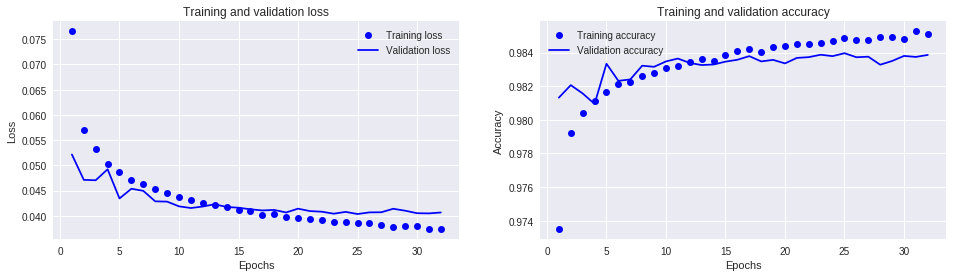

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 70s 2ms/step
([0.039209704157755834, 0.9843594823999687], 0.9901163910582939)
